In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time as time
import itertools as it
import skimpy as skim
import sklearn as sk
from sklearn import metrics
from sklearn import impute
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import xgboost as xgb

In [67]:
data = pd.read_csv('Life Expectancy Data.csv')
data = skim.clean_columns(data)

In [68]:
print(data.describe())

              year  life_expectancy  adult_mortality  infant_deaths  \
count  2938.000000      2928.000000      2928.000000    2938.000000   
mean   2007.518720        69.224932       164.796448      30.303948   
std       4.613841         9.523867       124.292079     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.100000       144.000000       3.000000   
75%    2012.000000        75.700000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           alcohol  percentage_expenditure  hepatitis_b        measles  \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000       0.

In [44]:
data.head(5)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [45]:
# set aside 10% of data to test final model onn
test = data.sample(frac=0.1, random_state=1)
train = data.drop(test.index)

print(f"Number of training observations: {train.shape[0]}")
print(f"Number of testing observations: {test.shape[0]}")

Number of training observations: 2644
Number of testing observations: 294


In [46]:
# Add dummies for Development status
train = pd.get_dummies(data = train, columns = ['status'])
test = pd.get_dummies(data = test, columns = ['status'])

In [47]:
for column in train.columns:
    missing_values = train[column].isnull().sum()
    if missing_values > 0:
        print(f'{column} has {missing_values} n/a values')

life_expectancy has 6 n/a values
adult_mortality has 6 n/a values
alcohol has 179 n/a values
hepatitis_b has 510 n/a values
bmi has 30 n/a values
polio has 18 n/a values
total_expenditure has 210 n/a values
diphtheria has 18 n/a values
gdp has 401 n/a values
population has 587 n/a values
thinness_1_19_years has 30 n/a values
thinness_5_9_years has 30 n/a values
income_composition_of_resources has 154 n/a values
schooling has 151 n/a values


In [48]:
def fill_na_data(data):
    for col in data.columns:
        train[col] = train[col].fillna(method='bfill')

In [49]:
fill_na_data(train)

In [50]:
# drop adult mortality, under 5 deaths, and infant deaths as a predictor since that is the same as life expectancy
# also dropping  year, GDP, and Population since those are not predictors countries can control
train.drop(columns = ['adult_mortality', 'infant_deaths', 'under_five_deaths','gdp','year', 'population'], inplace = True)
test.drop(columns = ['adult_mortality', 'infant_deaths','under_five_deaths','gdp', 'year','population'], inplace = True)

In [51]:
train.columns

Index(['country', 'life_expectancy', 'alcohol', 'percentage_expenditure',
       'hepatitis_b', 'measles', 'bmi', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling', 'status_Developed',
       'status_Developing'],
      dtype='object')

In [52]:
train = train.dropna()
test = test.dropna()

In [53]:
X = train[['alcohol', 'percentage_expenditure',
       'hepatitis_b', 'measles', 'bmi', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling', 'status_Developed',
       'status_Developing']]
X_test = test[['alcohol', 'percentage_expenditure',
       'hepatitis_b', 'measles', 'bmi', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling', 'status_Developed',
       'status_Developing']]

y = train[['life_expectancy']]
y_test = test[['life_expectancy']]

In [54]:
X.describe()

,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,polio,total_expenditure,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000
mean,4.500242,736.205128,81.834342,2392.202345,38.588994,82.743949,5.966895,82.637292,1.717738,4.818343,4.839713,0.636739,12.198033
std,4.067714,1989.971310,23.840825,11105.292356,20.035491,23.142436,2.512196,23.282349,4.891351,4.397819,4.483596,0.209997,3.450541
min,0.010000,0.000000,1.000000,0.000000,1.000000,3.000000,0.370000,2.000000,0.100000,0.100000,0.100000,0.000000,0.000000
25%,0.610000,4.405837,78.000000,0.000000,19.475000,78.000000,4.280000,78.000000,0.100000,1.600000,1.500000,0.501000,10.200000
50%,3.585000,63.059614,92.000000,18.000000,43.800000,93.000000,5.780000,93.000000,0.100000,3.400000,3.400000,0.684000,12.500000
75%,7.600000,443.362385,97.000000,373.500000,56.400000,97.000000,7.570000,97.000000,0.800000,7.200000,7.200000,0.791000,14.600000
max,17.870000,19479.911610,99.000000,212183.000000,87.300000,99.000000,17.600000,99.000000,50.600000,27.700000,28.600000,0.948000,20.700000


# Bagging


I started with the first non-linear approach, which was bagging. My primary concern was finding the right number of trees to bag. By examining a plot of model accuracy versus the number of trees, I noticed that both the test and out-of-bag RMSE decreased rapidly after bagging only a few trees. To fine-tune the model, I explored a narrower range of tree numbers (150, 200, 250) as potential estimators.

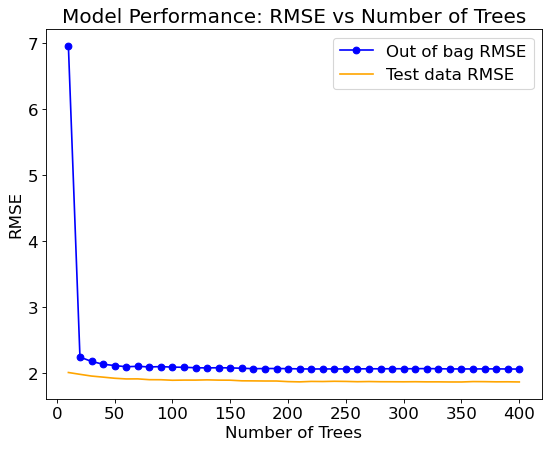

In [57]:
metrics_dict = {'oob_rsquared': {}, 'test_rsquared': {}, 'oob_rmse': {}, 'test_rmse': {}}

# Iterating over different tree counts
tree_counts = np.linspace(10, 400, 40, dtype=int)
for trees in tree_counts:
    reg_model = BaggingRegressor(estimator=DecisionTreeRegressor(),
                                 n_estimators=trees, random_state=1,
                                 n_jobs=-1, oob_score=True)
    reg_model.fit(X, y)
    
    metrics_dict['oob_rsquared'][trees] = reg_model.oob_score_
    metrics_dict['test_rsquared'][trees] = reg_model.score(X_test, y_test)
    metrics_dict['oob_rmse'][trees] = np.sqrt(mean_squared_error(y, reg_model.oob_prediction_))
    metrics_dict['test_rmse'][trees] = np.sqrt(mean_squared_error(y_test, reg_model.predict(X_test)))

# Plotting RMSE
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(metrics_dict['oob_rmse'].keys(), metrics_dict['oob_rmse'].values(), label='Out of bag RMSE', marker='o', color='blue')
plt.plot(metrics_dict['test_rmse'].keys(), metrics_dict['test_rmse'].values(), label='Test data RMSE', color = 'orange')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Model Performance: RMSE vs Number of Trees')
plt.legend()
plt.show()

In [70]:
tuning_parameters = {
    'estimator': [DecisionTreeRegressor(random_state=1), LinearRegression()],
    'n_estimators': [150, 200, 250],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

cross_validation = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(estimator=BaggingRegressor(random_state=1, n_jobs=-1),
                           param_grid=tuning_parameters, cv=cross_validation, 
                           n_jobs=-1, verbose=1)

# Reshape y to be one-dimensional
y_reshaped = y.values.ravel() if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series) else y.ravel()

# Fit the grid search model
grid_search.fit(X, y_reshaped)

print(f'Train R^2 Score : {grid_search.best_estimator_.score(X, y_reshaped):.3f}')
print(f'Test R^2 Score : {grid_search.best_estimator_.score(X_test, y_test):.3f}')
print(f'Best R^2 Score Through Grid Search : {grid_search.best_score_:.3f}')
print('Best Parameters : ', grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train R^2 Score : 1.000
Test R^2 Score : 0.948
Best R^2 Score Through Grid Search : 0.951
Best Parameters :  {'bootstrap': False, 'bootstrap_features': True, 'estimator': DecisionTreeRegressor(random_state=1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


In [20]:
bag_model = BaggingRegressor(DecisionTreeRegressor(random_state=1), 
                         n_estimators= 200, 
                         max_samples = 1.0,
                         max_features = 1.0,
                         bootstrap = False,
                         bootstrap_features = True,
                         random_state=1,
                         n_jobs=-1)
bag_model.fit(X, y)

BaggingRegressor(bootstrap=False, bootstrap_features=True,
                 estimator=DecisionTreeRegressor(random_state=1),
                 n_estimators=200, n_jobs=-1, random_state=1)

In [21]:
bag_rmse = round(np.sqrt(mean_squared_error(test.life_expectancy, bag_model.predict(X_test))),3)
print("The optimized bagged model gave an RMSE = " + str(bag_rmse))

The optimized bagged model gave an RMSE = 1.833


This is an improvement from the linear base
model.

# Random Forest

I considered using random forest to reduce prediction errors further. Following a procedure similar to bagging, I optimized the random forest model. Surprisingly, the tuned RF model had a slightly higher RMSE (1.847) than the bagged one. Despite exploring different max_features and n_estimators values, I couldn't achieve a lower error with random forest compared to bagging

In [61]:
X.shape

(2644, 15)

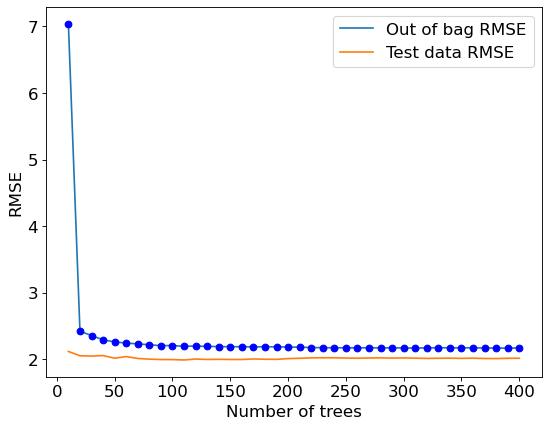

In [63]:
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}

for i in np.linspace(10,400,40,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns out-of_bag R-squared value
    test_rsquared[i]=model.score(X_test,y_test) #Returns test R-squared value
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))
    test_rmse[i]=np.sqrt(mean_squared_error(model.predict(X_test),y_test))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

In [64]:
parameter_ranges = {
    'n_estimators': [100, 250, 500],
    'max_features': range(1, 10)
}

parameter_combinations = list(it.product(*(parameter_ranges[param] for param in parameter_ranges)))

oob_scores = [0] * len(parameter_combinations)

for idx, combination in enumerate(parameter_combinations):
    rf_model = RandomForestRegressor(n_estimators=combination[0], max_features=combination[1],
                                     random_state=1, oob_score=True, verbose=False, n_jobs=-1)
    rf_model.fit(X, y)
    oob_scores[idx] = rf_model.oob_score_

best_params_index = np.argmax(oob_scores)
print("Optimal Parameters:", parameter_combinations[best_params_index])
print("Highest R-squared Score:", max(oob_scores))

Optimal Parameters: (500, 9)
Highest R-squared Score: 0.9559334596508698


In [26]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=1,
                        n_jobs=-1, max_features=9).fit(X, y)
#RMSE on test data
rf_rmse = round(np.sqrt(mean_squared_error(test.life_expectancy, rf_model.predict(X_test))),3)
print("The optimized RF model gave an RMSE = " + str(rf_rmse))

The optimized RF model gave an RMSE = 1.847


# Boosting

The last tree-based modeling approaches I used included three boosting methods: Adaptive boosting, Gradient boost, and XGBoost. Each of these models had slightly different parameters requiring tuning, with the most crucial ones being the learning rates and max_depths. These parameters dictated the rate at which the boosting model learned to predict life expectancies.

## AdaBoost

In [27]:
model = AdaBoostRegressor(random_state=1)

grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'estimator': [DecisionTreeRegressor(max_depth=depth) for depth in [3, 5, 10, 15]]
}

# defining the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')

grid_result = grid_search.fit(X, y)

# summarizing the best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

Best: -3.792638 using {'estimator': DecisionTreeRegressor(max_depth=15), 'learning_rate': 1.0, 'n_estimators': 100}


In [28]:
# tuned AdaBoost Model - but used a lower learning rate than optimal parameter (similar RMSE either way)
ada_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=15),n_estimators=100,learning_rate=0.1,
                         random_state=1).fit(X,y)
#RMSE on test data
ada_rmse = round(np.sqrt(mean_squared_error(test.life_expectancy, ada_model.predict(X_test))),3)
print("The optimized AdaBoost model gave an RMSE = " + str(ada_rmse))

The optimized AdaBoost model gave an RMSE = 1.679


## Gradient Boost

In [29]:
# finding tuned params for Gradient Boost model
model = GradientBoostingRegressor(random_state=1,loss='huber')
grid = dict()
grid['n_estimators'] = [100,200,500]
grid['learning_rate'] = [0.001, 0.01, 0.1]
grid['max_depth'] = [2,3,5]
# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversion

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversion

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversion

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversion

/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fred/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversion

Best: 2.228028 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [30]:
# tuned Gradient Boost model
gr_model = GradientBoostingRegressor(max_depth=5,n_estimators=500,learning_rate=0.1,
                         random_state=1,loss='huber').fit(X,y)
# RMSE on test data
gr_rmse = round(np.sqrt(mean_squared_error(test.life_expectancy, gr_model.predict(X_test))),3)
print("The optimized Gradient Boost model gave an RMSE = " + str(gr_rmse))

The optimized Gradient Boost model gave an RMSE = 1.978


## XG Boost

In [32]:
# tuning XG boost params
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.05,0.1,0.2],
               'reg_lambda':[0,0.01,0.001],
                'n_estimators':[100, 250, 500]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimal parameter values = {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'reg_lambda': 0}


In [33]:
# tuned XG Boost model
xg_model = xgb.XGBRegressor(random_state=1,max_depth=7,n_estimators=500,
                                         learning_rate = 0.1,reg_lambda=0).fit(X,y)
# RMSE on test data
xg_rmse = round(np.sqrt(mean_squared_error(test.life_expectancy, xg_model.predict(X_test))),3)
print("The optimized XGBoost model gave an RMSE = " + str(xg_rmse))

The optimized XGBoost model gave an RMSE = 1.83


# Ensemble Model 

After assembling the initial models, I decided to combine the models into an ensemble. Since the bagging model provided a lower RMSE than the random forest, I chose to incorporate it along with the three boosting models: AdaBoost, Gradient Boosting, and XGBoost. I attempted a voting regression with equal weight for all four models, resulting in an RMSE of 1.742, which did not improve upon the AdaBoost model. I created a stacking ensemble that assigned different weights to each of the four models' predictions. The result was a model with 24% weight for bagging, 62% for AdaBoost, 2% for Gradient Boosting, and 12% for XGBoost, achieving an RMSE of 1.667, which represented an improvement over my previous best model.

In [38]:
# Voting ensemble
m1 = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1), 
                         n_estimators= 200, 
                         max_samples = 1.0,
                         max_features = 1.0,
                         bootstrap = False,
                         bootstrap_features = True,
                         random_state=1,
                         n_jobs=-1)
m2 = rf_model = RandomForestRegressor(n_estimators=500, random_state=1,
                        n_jobs=-1, max_features=9)
m3 = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=15),n_estimators=100,learning_rate=0.1,
                         random_state=1)
m4 = GradientBoostingRegressor(max_depth=5,n_estimators=500,learning_rate=0.1,
                         random_state=1,loss='huber')
m5 = xgb.XGBRegressor(random_state=1,max_depth=7,n_estimators=500,
                                         learning_rate = 0.1,reg_lambda=0)

en1=VotingRegressor(estimators = [('bag',m1),('rf',m2),('ada',m3),('gb',m4), ('xgb',m5)])
en1.fit(X,y)
print("Ensemble model RMSE = ", round(np.sqrt(mean_squared_error(en1.predict(X_test),y_test)),3))

Ensemble model RMSE =  1.741


In [40]:
#Stacking using LinearRegression as the meta-model
en=StackingRegressor(estimators = [('r',rf_model),('ada',ada_model),('gb',gr_model), ('xgb', xg_model)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X,y)
print("Stacking model RMSE = ", round(np.sqrt(mean_squared_error(en.predict(X_test),y_test)),3))

Stacking model RMSE =  1.674


In [ ]:
en.final_estimator_.coef_

In [ ]:
#Meta stacking w/ voting and ensemble
metastack=StackingRegressor(estimators = [('r',rf_model),('ada',ada_model),('gb',gr_model), ('xgb', xg_model), ('voting', en1), ('stack', en)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
metastack.fit(X,y)
print("Stacking model RMSE = ", round(np.sqrt(mean_squared_error(metastack.predict(X_test),y_test)),3))

In [38]:
metastack.final_estimator_.coef_

array([-0.2732351 ,  0.37710817, -0.22546035, -0.11494021,  0.62544742,
        0.62544742])

In [40]:
#Stacking using LinearRegression as the meta-model - including random forest
enbag=StackingRegressor(estimators = [("bag", bag_model),('r',rf_model),('ada',ada_model),('gb',gr_model), ('xgb', xg_model)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
enbag.fit(X,y)
print("Stacking model RMSE = ", round(np.sqrt(mean_squared_error(enbag.predict(X_test),y_test)),3))

Stacking model RMSE =  1.666


In [41]:
enbag.final_estimator_.coef_

array([ 0.25017897, -0.02305614,  0.62728714,  0.02471862,  0.13523876])

In [25]:
#Stacking using LinearRegression as the meta-model - excluding random forest
enbag2=StackingRegressor(estimators = [("bag", bag_model),('ada',ada_model),('gb',gr_model), ('xgb', xg_model)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
enbag2.fit(X,y)
print("Stacking model RMSE = ", round(np.sqrt(mean_squared_error(enbag2.predict(X_test),y_test)),3))

Stacking model RMSE =  1.667


In [26]:
enbag2.final_estimator_.coef_

array([0.24090916, 0.62301228, 0.01744543, 0.13323205])

# Features for the Models

Are there predictors that are more important across all 4 models in the final ensemble?

### AdaBoost model

In [35]:
ada_df = pd.DataFrame({'Predictor': X.columns, 'Feature Importance': ada_model.feature_importances_})

In [37]:
ada_df.sort_values(by='Feature Importance', ascending=False)

,Predictor,Feature Importance
8,hiv_aids,0.625349
11,income_composition_of_resources,0.171578
12,schooling,0.041872
10,thinness_5_9_years,0.029755
6,total_expenditure,0.025411
4,bmi,0.022561
0,alcohol,0.018904
9,thinness_1_19_years,0.016090
3,measles,0.013438
7,diphtheria,0.009770


### Gradient Boost Model

In [39]:
gr_df = pd.DataFrame({'Predictor': X.columns, 'Feature Importance': gr_model.feature_importances_})
gr_df.sort_values(by='Feature Importance', ascending=False)

,Predictor,Feature Importance
8,hiv_aids,0.612581
11,income_composition_of_resources,0.188971
12,schooling,0.041898
10,thinness_5_9_years,0.040953
4,bmi,0.022849
9,thinness_1_19_years,0.017106
6,total_expenditure,0.016632
3,measles,0.015232
0,alcohol,0.014386
5,polio,0.011266


### XG Boost Model

In [41]:
xg_df = pd.DataFrame({'Predictor': X.columns, 'Feature Importance': xg_model.feature_importances_})
xg_df.sort_values(by='Feature Importance', ascending=False)

,Predictor,Feature Importance
8,hiv_aids,0.723722
11,income_composition_of_resources,0.091084
10,thinness_5_9_years,0.056881
12,schooling,0.030306
13,status_Developed,0.024005
4,bmi,0.015292
9,thinness_1_19_years,0.014556
5,polio,0.010498
7,diphtheria,0.009695
6,total_expenditure,0.008952


### Bagging Model

In [42]:
bag_feature_importances = np.mean([tree.feature_importances_ for tree in bag_model.estimators_], axis=0)

In [43]:
bag_df = pd.DataFrame({'Predictor': X.columns, 'Feature Importance': bag_feature_importances})
bag_df.sort_values(by='Feature Importance', ascending=False)

,Predictor,Feature Importance
0,alcohol,0.085485
8,hiv_aids,0.079951
3,measles,0.077401
2,hepatitis_b,0.073283
9,thinness_1_19_years,0.071667
1,percentage_expenditure,0.069741
10,thinness_5_9_years,0.067867
4,bmi,0.064424
12,schooling,0.063753
5,polio,0.063367


# Takeaway

In 3 of the 4 sub-models, HIV/AIDS stood out as the most crucial feature. Additionally, ICOR, schooling, and thinness were consistently present in the top 4 features for 3 out of 4 sub-models and held significant importance in the ensemble's weight.

Governments, NGOs, and IGOs should prioritize efforts to reduce the spread of HIV/AIDS by enhancing sexual education and increasing access to contraceptives. In addition to this, our stakeholders should concentrate on improving economic development, enhancing educational opportunities, and addressing issues related to malnutrition.